<a href="https://colab.research.google.com/github/sophiascarano/hybrid_quantum_classical_KiUNet/blob/main/messy_drafts/BrainTumor_oldData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

import json
import os
import cv2
from PIL import Image
from skimage.draw import polygon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("image files you can choose from: ")
!ls '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/test/'

image files you can choose from: 
217.jpg  218.jpg  219.jpg  220.jpg  annotations_test.json


In [ ]:
# set default paths

dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/'
subset = 'train'

dataset_dir = os.path.join(dataset_dir, subset)
annotations = json.load(open(os.path.join(dataset_dir, 'annotations_'+subset+'.json')))
annotations = list(annotations.values())
annotations

# to do:

- DONE make sure all images are the appropriate size (256 x 256)
- DONE figure out how to get all of the image names into one list, based on the input of "test", "train", or "val" as the 'subset' variable.
- DONE find out if each image in train, val, and test has a mask in its respective annotations JSON file. If not, figure out what to do with the images that don't have a mask. (just leave them blank?) or still have a pixel mask, but all the values are 0
  - numpy tensor of 0's? `numpy.zeros(width, height of the image)`?
- DONE figure out how to create a filled in polygon based on the mask coordinates, and highlight those respective pixels as '1' and the rest as '0'
- figure out how to visualize this mask overlay, where the pixels with value '1' are semi-transparent with the color green, representing ground truth. This will be the ground truth pixels.
- figure out how to get this in a usable format for a segmentation algorithm.
  - look to coursera for help with this step. I'm sure they have examples.


In [ ]:
def get_image(img_name):
  img_path = f'{IMAGE_DIR}/{img_name}'
  image = load_img("{}".format(img_path))

  return image

def load_img(path_to_img):
    '''loads an image as a tensor and scales it to 512 pixels'''
    max_dim = 256
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image

def get_annot(subset_folder):
  dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/'
  subset = subset_folder

  dataset_dir = os.path.join(dataset_dir, subset)
  annotations = json.load(open(os.path.join(dataset_dir, 'annotations_'+subset+'.json')))
  annotations = list(annotations.values())

  return annotations

def get_polygon_coords(img_name, subset_folder):
  newDict = dict()
  this_annot = []

  annotations = get_annot(subset_folder)

  # iterate over each labeled image?
  for i in range(len(annotations)):

    # Iterate over all the items in dictionary and filter items which has correct keys
    for (key, value) in annotations[i].items():
      # Check if value is correct then add pair to new dictionary
      if key == 'filename':
        if value == img_name:
          newDict[key] = value
          this_annot.append(annotations[i])


  # for (key, value) in this_annot[0].items():
  #   if key == 'regions':

  #but there might be multiple polygons in an image, so we need to iterate through 'regions'
  this_x = []
  this_y = []
  for i in range(len(this_annot[0].get('regions', {}))):
    this_x.append(this_annot[0].get('regions', {})[i].get('shape_attributes').get('all_points_x'))
    this_y.append(this_annot[0].get('regions', {})[i].get('shape_attributes').get('all_points_y'))
  
  these_coords = []
  for j in range(len(this_x)):
    these_coords_indiv = [(this_x[j][i], this_y[j][i]) for i in range(0, len(this_x[j]))]
    these_coords.append(these_coords_indiv)

  return these_coords


def all_imgs(subset_folder):
  '''
  given the subset folder mounted at my google drive, return a list of all files
  ending with .jpg
  '''
  # make sure to have correct path
  dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/'
  subset = subset_folder
  dataset_dir = os.path.join(dataset_dir, subset)
  # initialize empty lsit
  img_names = []
  for filename in os.listdir(dataset_dir):
    if filename.endswith("jpg"):
      # for all files that end in .jpg, add to list
      img_names.append(filename)
  return img_names

def all_imgs_with_mask(subset_folder):
  '''
  given the subset folder mounted at my google drive, go through its respective
  annotations .json file and make a list of all files that have polygon mask
  coordinates
  '''
  # first, compile list of files that have polygons in the annotations folder
  # for each key "filename", append the value to the list ("with_mask")
  with_mask = []
  annot = get_annot(subset_folder)
  # each item in list represents information about a separate picture
  for x in annot:
    with_mask.append(x.get('filename'))
  return with_mask

def imgs_no_mask(subset_folder):
  '''
  return a list of all files that are listed in the subset folder, but do not 
  have an associated annotated polygon. This should yeild an empty list for 
  all three subset folders.
  '''
  all_names = all_imgs(subset_folder)
  all_masked = all_imgs_with_mask(subset_folder)
  no_mask = list(set(all_names) - set(all_masked))
  return no_mask

def get_all_polygon_coords(subset_folder):
  '''
  this returns a list of tuples containing the image name and that image's list
  of all polygon coordinates
  
  [(image name, [all polygon coordinates]), ...]
  '''
  # make list of all image names in this folder
  img_names = all_imgs(subset_folder)
  #initialize empty list
  all_polygons = []
  all_names = []
  #iterate through img_names, extracting the polygon coordinates and appending them to all_polygons
  for i in img_names:
    all_polygons.append(get_polygon_coords(i, subset_folder))
    all_names.append(i)

  tuples_of_names_and_polygons = [(all_names[i], all_polygons[i]) for i in range(0, len(all_names))]
  return tuples_of_names_and_polygons

def get_polygon_coords_lists(img_name, subset_folder):
  # get polygon coords
  annotations = get_annot(subset_folder)

  newDict = dict()
  this_annot = []
  # iterate over each labeled image?
  for i in range(len(annotations)):
    # Iterate over all the items in dictionary and filter items which has correct keys
    for (key, value) in annotations[i].items():
      # Check if value is correct then add pair to new dictionary
      if key == 'filename':
        if value == img_name:
          newDict[key] = value
          this_annot.append(annotations[i])

  #but there might be multiple polygons in an image, so we need to iterate through 'regions'
  this_x = []
  this_y = []
  for i in range(len(this_annot[0].get('regions', {}))):
    this_x.append(this_annot[0].get('regions', {})[i].get('shape_attributes').get('all_points_x'))
    this_y.append(this_annot[0].get('regions', {})[i].get('shape_attributes').get('all_points_y'))
  return this_x, this_y

def get_all_polygon_coords_lists(subset_folder):
  '''
  this returns a list of tuples containing the image name and that image's list
  of all polygon coordinates
  
  [(image name, [[all polygon x coordinates]], [[all polygon y coordinates]]), ...]

  which can also be shown as

  [(image name, [[polygon1_x_coords], [polygon2_x_coords], ...], [[polygon1_y_coords], [polygon2_y_coords], ...]), ...]

  This format is very useful when plotting masks!

  '''
  # make list of all image names in this folder
  img_names = all_imgs(subset_folder)
  #initialize empty list
  all_polygon_x_coords = []
  all_polygon_y_coords = []
  all_names = []
  #iterate through img_names, extracting the polygon coordinates and appending them to all_polygons
  for i in img_names:
    all_polygon_x_coords.append(get_polygon_coords_lists(i, subset_folder)[0])
    all_polygon_y_coords.append(get_polygon_coords_lists(i, subset_folder)[1])
    all_names.append(i)

  tuples_of_names_and_polygons = [(all_names[i], all_polygon_x_coords[i], all_polygon_y_coords[i]) for i in range(0, len(all_names))]
  return tuples_of_names_and_polygons

In [ ]:
def mask_array(img_name, subset_folder):
  '''
  returns array of size 256x256, where 0's represent no tumor, and 1's represent
  the area that is bound by the tumor, which is a polygon shape
  '''
  # first initialize shape of array
  img = np.zeros((256, 256), dtype=np.uint8)
  # need to get lists of all x's and y's for that shape
  x_coord_list, y_coord_list = get_polygon_coords_lists(img_name, subset_folder)
  # iterate through all polygons in list
  i = 0
  while i < len(x_coord_list):
    r = np.array(y_coord_list[i])
    c = np.array(x_coord_list[i])
    rr, cc = polygon(r, c)
    img[rr, cc] = 1
    # do I need this? or is this only for while loops?
    i += 1
  
  # then can use this info for drawing polygon
  return img


def draw_polygon_array(img_name, subset_folder):
  img = mask_array(img_name, subset_folder)
  plt.imshow(img, interpolation='nearest', cmap='gray', vmin=0, vmax=1, )
  plt.show()  

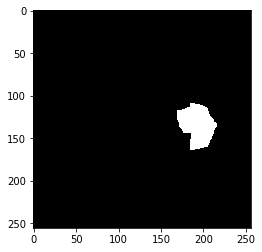

In [ ]:
draw_polygon_array(img_name = '218.jpg', subset_folder = 'test')

In [ ]:
image = Image.open('/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/train/0.jpg')
#mage to open
width, height = image.size
#extract width and height from output tuple
print(width, height)

256 256


In [ ]:
get_all_polygon_coords('test')

[('220.jpg',
  [[(196, 118),
    (206, 125),
    (206, 134),
    (196, 145),
    (182, 150),
    (172, 162),
    (160, 162),
    (154, 160),
    (154, 147),
    (148, 131),
    (153, 124),
    (156, 117),
    (163, 111),
    (176, 108)]]),
 ('219.jpg',
  [[(106, 160),
    (112, 173),
    (114, 189),
    (119, 212),
    (107, 206),
    (98, 198),
    (97, 211),
    (93, 216),
    (80, 216),
    (71, 215),
    (64, 207),
    (63, 196),
    (65, 180),
    (62, 166),
    (66, 156),
    (76, 148),
    (86, 147),
    (96, 145),
    (105, 145),
    (108, 152)]]),
 ('218.jpg',
  [[(196, 110),
    (205, 115),
    (208, 124),
    (216, 134),
    (210, 148),
    (205, 160),
    (196, 162),
    (183, 164),
    (184, 152),
    (185, 145),
    (176, 143),
    (171, 135),
    (169, 128),
    (169, 118),
    (184, 113),
    (184, 108)]]),
 ('217.jpg',
  [[(171, 96),
    (162, 104),
    (156, 114),
    (162, 136),
    (168, 144),
    (177, 148),
    (187, 149),
    (198, 145),
    (206, 140),
    (211,

In [ ]:
pics_no_mask('val')

[]

https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon

In [ ]:
get_all_polygon_coords_lists('train')

In [ ]:
from skimage.draw import polygon
img = np.zeros((100, 100), dtype=np.uint8)

r = np.array([10, 20, 80])
c = np.array([10, 70, 40])
rr, cc = polygon(r, c)
img[rr, cc] = 1

r = np.array([1, 10, 5])
c = np.array([60, 60, 80])
rr, cc = polygon(r, c)
img[rr, cc] = 1

img
# img = Image.fromarray(img, )
# img.save('my.png')
# img.show()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

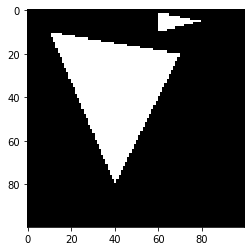

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest', cmap='gray', vmin=0, vmax=1, )
plt.show()

In [ ]:
from PIL import Image

In [ ]:
img = Image.fromarray(img, 'RGB')
img.save('my.png')
img.show()

TypeError: ignored

In [ ]:
def view_image(img_name):
  img_path = f'{IMAGE_DIR}/{img_name}'
  image = load_img("{}".format(img_path))
  if len(image.shape) > 3:
          image = tf.squeeze(image, axis=0)

  plt.imshow(image)

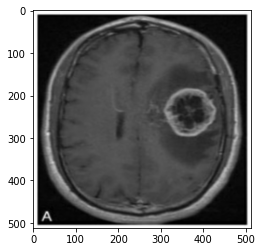

In [ ]:
img_viz = view_image('217.jpg')

# Create Mask

In [ ]:
annotations[0]

{'file_attributes': {},
 'filename': '217.jpg',
 'regions': [{'region_attributes': {},
   'shape_attributes': {'all_points_x': [171,
     162,
     156,
     162,
     168,
     177,
     187,
     198,
     206,
     211,
     214,
     210,
     204,
     195,
     182],
    'all_points_y': [96,
     104,
     114,
     136,
     144,
     148,
     149,
     145,
     140,
     130,
     120,
     106,
     99,
     93,
     93],
    'name': 'polygon'}}],
 'size': 19113}

In [ ]:
this_dict = annotations('filename' == '217.jpg')

TypeError: ignored

In [ ]:
import numpy as np
import cv2

pts = np.array([[542, 107], [562, 102], [582, 110], [598, 142], [600, 192], [601, 225], [592, 261], [572, 263], [551, 245], [526, 220], [520, 188], [518, 152], [525, 127], [524, 107]], dtype=np.int32)

mask = np.zeros((img.shape[0], img.shape[1]))

cv2.fillConvexPoly(mask, pts, 1)
mask = mask.astype(np.bool)

out = np.zeros_like(img)
out[mask] = img[mask]

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
cv2_imshow(out)
cv2.waitKey(0)
cv2.destroyAllWindows()

TypeError: ignored

In [ ]:
content_path = f'{IMAGE_DIR}/217.jpg'
style_path = f'{IMAGE_DIR}/218.jpg'

In [ ]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

In [ ]:
def tensor_to_image(tensor):
    '''converts a tensor to an image'''
    tensor_shape = tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
    '''loads an image as a tensor and scales it to 512 pixels'''
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image


def load_images(content_path, style_path):
    '''loads the content and path images as tensors'''
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image


def imshow(image, title=None):
    '''displays an image with a corresponding title'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
    '''displays a row of images with corresponding titles'''
    if len(images) != len(titles):
        return

    plt.figure(figsize=(20, 12))
    for idx, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([])
        plt.yticks([])
        imshow(image, title)


def display_gif(gif_path):
    '''displays the generated images as an animated gif'''
    with open(gif_path,'rb') as f:
        display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
    '''creates animation of generated images'''
    mimsave(gif_path, images, fps=1)

    return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
    '''clips the image pixel values by the given min and max'''
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
    '''centers the pixel values of a given image to use with VGG-19'''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)

    return image

# Overview

- I will be using the data found at https://github.com/ruslan-kl/brain-tumor 
- This data is for instance segmentation of brain tumors
- It seems that there is a polygon mask overlaying each of the tumors, so that's what I'll use to train


In [ ]:
import os
import tensorflow as tf

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls "/content/drive/MyDrive"

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/' # directory with image data

In [ ]:
!ls '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/data_cleaned/'

annotations_all.json  test  train  val


In [ ]:
train_data_dir = 'data/training'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test' 
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),
     ' %', '\n - # of epochs: ', epochs, '\n - batch size: ', batch_size)


## Build the custom brain MRI data set.

Dataset class provides a consistent way to work with any dataset. We will create our new datasets for brain images to train without having to change the code of the model.

Dataset class also supports loading multiple data sets at the same time. This is very helpful when you want to detect different objects and they are all not available in one data set.

In the ***load_dataset*** method, we iterate through all the files in the image and annotations folders to add the class, images, and annotations to create the dataset using ***add_class*** and ***add_image*** methods.

***extract_boxes*** method extracts each of the bounding boxes from the annotation file. Annotation files are XML files using Pascal VOC format. It returns the box, it’s height and width

***load_mask*** method generates the masks for every object in the image. It returns one mask per instance and class ids, a 1D array of class id for the instance masks

***image_reference*** method returns the path of the image.

In [ ]:
ABS_PATH = '/content/drive/MyDrive/Colab_Notebooks/brain_tumor/brain-tumor/'
DATA_PATH = os.path.join(ABS_PATH, 'data_cleaned/')
 
TRAIN_DIR = os.path.join(DATA_PATH, 'train')
TEST_DIR = os.path.join(DATA_PATH, 'test')
VAL_DIR = os.path.join(DATA_PATH, 'val')

ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

In [ ]:
class BrainScanDataset(tf.utils.Dataset):
  def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the Brain Scan dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")# Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )
  
  def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)# Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1# Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
  
  def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

AttributeError: ignored